In [ ]:
#INSTALLING FAKER LIBRARY TO GENERATE FAKE DATA
pip install faker


In [1]:
#IMPORTING LIBRARIES FOR THE HANDLING THE DATAFRAME AND GENERATE RANDOM FAKE DATA
import pandas as pd
import numpy as np
from faker import Faker
import random


In [2]:

from scipy.optimize import fsolve

In [3]:
#INITIALIZE THE FAKER
fake = Faker()

In [4]:
#GENERATING THE FAKE DATA FOR THE LOAN DEFAULT
def generate_fake_loan_data(num_records=20000):
    data = {
        "customer_id": [i for i in range(1, num_records + 1)], 
        "name": [fake.name() for _ in range(num_records)],  
        "age": [fake.random_int(min=21, max=65) for _ in range(num_records)],  
        "income": [fake.random_int(min=30000, max=150000) for _ in range(num_records)],  
        "credit_score": [fake.random_int(min=300, max=850) for _ in range(num_records)], 
        "loan_term": [np.random.choice([12, 24, 36, 48, 60]) for _ in range(num_records)],
     
    }
    df = pd.DataFrame(data)
    
    def calculate_loan_amount(row):
        if row['credit_score'] < 580:
            max_loan = 10000
        elif row['credit_score'] < 670:
            max_loan = 20000
        elif row['credit_score'] < 740:
            max_loan = 35000
        else:
            max_loan = 50000
        
        if row['income'] < 50000:
            loan_amount = max_loan * 0.4
        elif row['income'] <= 100000:
            loan_amount = max_loan * 0.7
        else:
            loan_amount = max_loan * 1.0
        
        return loan_amount
    
    df["loan_amount"] = df.apply(calculate_loan_amount, axis=1)
    
    def calculate_monthly_installment(loan_amount, loan_term):
        temp_interest_rate = np.random.uniform(5, 15) / 100
        r = temp_interest_rate / 12
        n = loan_term
        emi = loan_amount * r * (1 + r)**n / ((1 + r)**n - 1)
        return emi
    
    df["monthly_installment"] = df.apply(lambda x: calculate_monthly_installment(x["loan_amount"], x["loan_term"]), axis=1)
    
    def calculate_interest_rate(row):
        def interest_function(r):
            P = row["loan_amount"]
            n = row["loan_term"]
            EMI = row["monthly_installment"]
            return EMI - (P * r * (1 + r)**n) / ((1 + r)**n - 1)
        
        r_initial_guess = 0.01
        monthly_rate = fsolve(interest_function, r_initial_guess)[0]
        annual_rate = monthly_rate * 12 * 100
        return annual_rate
    
    df["interest_rate"] = df.apply(calculate_interest_rate, axis=1)

    def calculate_repayment_status(row):
        if row['income'] < 50000 and row['credit_score'] < 600:
            return 0  
        
        if row['age'] > 55 and row['income'] < 80000:
            return 0  
        
        if row['loan_term'] in [48, 60] or row['interest_rate'] > 12:
            return 0 
        
        debt_to_income_ratio = row['loan_amount'] / row['income'] * 100
        if debt_to_income_ratio > 30: 
            return 0
        
        return 1

    df["repayment_status"] = df.apply(calculate_repayment_status, axis=1)

    
    return df

loan_data = generate_fake_loan_data(num_records=20000)

In [ ]:
# DISPLAY THE DATAFRAME
loan_data.head()

In [ ]:
#CHECKING NULL VALUES
loan_data.isna().sum()

In [7]:
#CHECKING DUPLICATE DATA
loan_data.duplicated().sum()

0

In [ ]:
#CHECKING THE INFO OF THE DATAFRAME
loan_data.info()

In [ ]:
#DESCRIBE THE DATAFRAME
loan_data.describe()

In [ ]:
#COUNTING THE COLUMNS VALUES
loan_data.count()

In [11]:
#IMPORTING DATA VISULIATION LIBRARIES FOR EDA AND CHECK OUTLIER
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: >

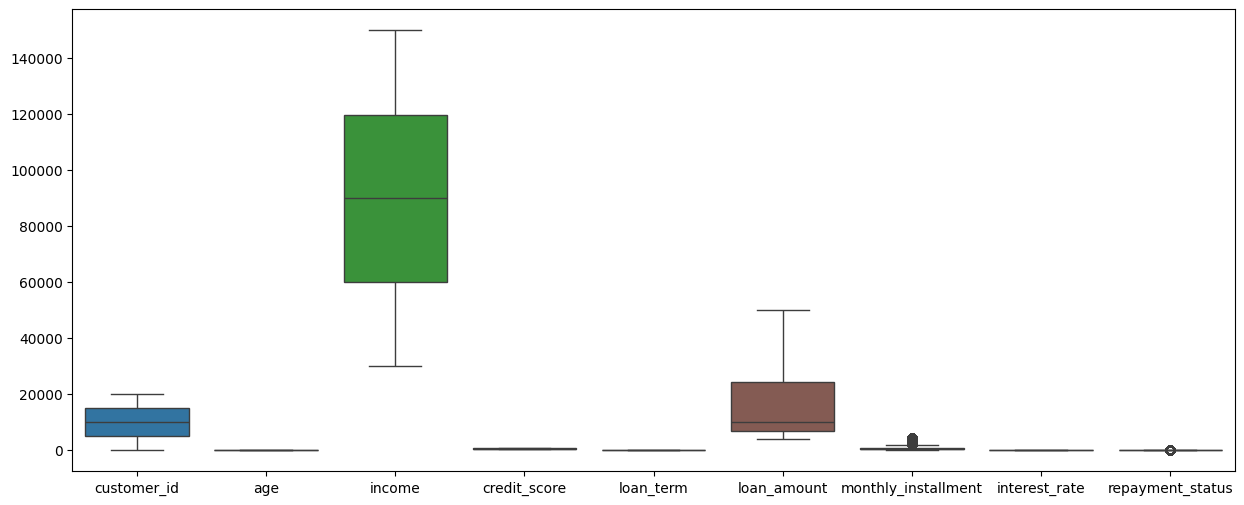

In [12]:
#CHECKING OUTLIER USING BOXPLOT
plt.figure(figsize=(15, 6))
sns.boxplot(data=loan_data)

In [ ]:
#CHECKING THE DATATYPES ARE CORRECT
loan_data.dtypes

In [14]:
#ROUNDING THE MONTHLY INSTALLMENT 
loan_data['monthly_installment'] = loan_data['monthly_installment'].round(1).astype(float)


In [15]:
#ROUNDING THE INTEREST RATE
loan_data['interest_rate'] = loan_data['interest_rate'].round(2).astype(float)

In [16]:
#CONVERTING LOAN AMOUNT TO INTEGER
loan_data['loan_amount'] = loan_data['loan_amount'].astype(int)

In [ ]:
#DISPLAY THE DATAFRAME AFTER ROUNDING THE DATA COLUMNS
loan_data.head()

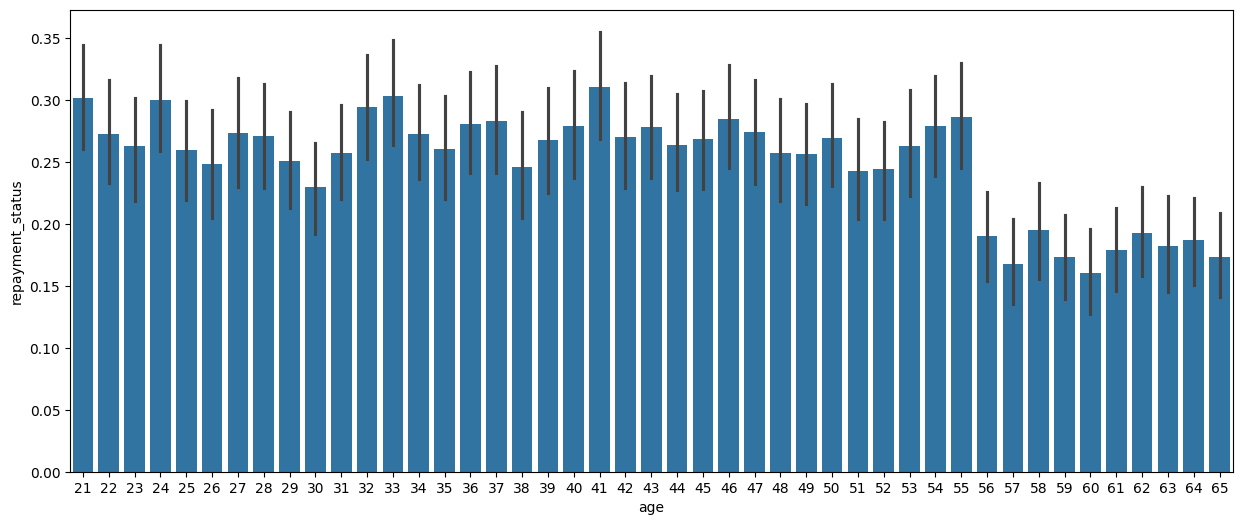

In [18]:
plt.figure(figsize=(15,6))
sns.barplot(x = 'age',y ='repayment_status', data = loan_data)
plt.show()

In [ ]:
#DISPLAY THE TOP 10 HIGH LOAN CUSTOMER
top_10_loan_data = loan_data[['name', 'loan_amount', 'repayment_status']].sort_values(by='loan_amount', ascending=False).head(20)

plt.figure(figsize=(25, 6))
sns.barplot(x='name', y='loan_amount', hue='repayment_status', data=top_10_loan_data)
plt.xticks(rotation=45)
plt.show()


In [ ]:
#TOP 10 HIGH INCOME CUSTOMERS
top_10_loan_data = loan_data[['name', 'income', 'repayment_status']].sort_values(by='income', ascending=False).head(20)

plt.figure(figsize=(25, 6))
sns.barplot(x='name', y='income', hue='repayment_status', data=top_10_loan_data)
plt.xticks(rotation=45)
plt.show()

In [ ]:
#COUNTING THE ROWS WHICH HAS REPAYMENT STATUS HAS 0 VALUES
count_default = loan_data[loan_data['repayment_status'] == 0].shape[0]
count_default


In [ ]:
#COUNTING THE ROWS WHICH HAS REPAYMENT STATUS HAS 1 VALUES
count_default = loan_data[loan_data['repayment_status'] == 1].shape[0]
count_default

In [ ]:
#INSTALLING THE IMBALANCES LEARN LIBRARY FOR BALANCES THE DATAFRAME
!pip install imbalanced-learn

In [ ]:
#IMPORTING THE SMOTE LIBRARY AND BALANCING THE DATAFRAME USING SMOTE 
from imblearn.over_sampling import SMOTE

X = loan_data.drop(columns=['customer_id', 'name', 'repayment_status']) 
y = loan_data['repayment_status']  

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

balanced_loan_data = pd.concat([X_smote, y_smote], axis=1)

print("Before SMOTE:")
print(y.value_counts())

print("\nAfter SMOTE:")
print(y_smote.value_counts())

In [ ]:
#IMPORTING LIBRARIES FOR TRAIN AND TEST THE MODELS
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

In [ ]:
#SETTING FEATURE AND TARGET COLUMN
X = balanced_loan_data[['age', 'income', 'credit_score', 'loan_term', 'loan_amount', 'monthly_installment', 'interest_rate']]
y = balanced_loan_data['repayment_status']

In [ ]:
#SPLITING THE DATA FOR TRAINING AND TESTING
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#DOING THE FEATURE SCALING USING THE STANDARD SCALER
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)       

In [ ]:
#TRAINING THE LOGISTIC REG MODEL
logistic_model = LogisticRegression()
model.fit(X_train_scaled, y_train)

In [ ]:
#CHECKING THE ACCURACY FOR TRAINED AND TEST DATA for logistic model
print("Training Accuracy:", logistic_model.score(X_train_scaled, y_train))
print("Test Accuracy:", logistic_model.score(X_test_scaled, y_test))

In [ ]:
#CHECKING THE PRECISION,RECALL AND F1 SCORE FOR LOGISTIC CLASSIFIER MODEL
y_pred = logistic_model.predict(X_test_scaled)
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))

In [ ]:
#CHECKING THE ROC AUC SCORE FOR LOGISTIC MODEL
y_prob = logistic_model.predict_proba(X_test_scaled)[:, 1]
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

In [33]:
#TRAINING THE RANDOM FOREST MODEL
random_forest = RandomForestClassifier(max_depth=3, random_state=42)
random_forest.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=3, random_state=42)

In [ ]:
#CHECKING THE ACCURACY FOR TRAINED AND TEST DATA FOR RANDOM FOREST MODEL
print("Training Accuracy:", random_forest.score(X_train_scaled, y_train))
print("Test Accuracy:", random_forest.score(X_test_scaled, y_test))

In [ ]:
#CHECKING THE PRECISION,RECALL AND F1 SCORE FOR RANDOM FOREST MODEL
model1_y_pred = random_forest.predict(X_test_scaled)
print("Precision:", precision_score(y_test, model1_y_pred))
print("Recall:", recall_score(y_test, model1_y_pred))
print("F1-Score:", f1_score(y_test, model1_y_pred))

In [ ]:
#CHECKING THE ROC AUC SCORE FOR RANDOM FOREST MODEL
y1_prob = model1.predict_proba(X_test_scaled)[:, 1]
print("ROC-AUC Score:", roc_auc_score(y_test, y1_prob))

In [ ]:
# ##TRAINING THE XGBOOST MODEL
xgboost_model= xgb.XGBClassifier(
    objective="binary:logistic",  
    colsample_bytree=0.3,        
    learning_rate=0.1,          
    max_depth=5,            
    alpha=10,                    
    n_estimators=100,            
    random_state=42             
)
xgboost_model.fit(X_train_scaled, y_train)

In [ ]:
# #CHECKING THE ACCURACY FOR TRAINED AND TEST DATA XGBOOST MODEL
print("Training Accuracy:", xgboost_model.score(X_train_scaled, y_train))
print("Test Accuracy:", xgboost_model.score(X_test_scaled, y_test))

In [ ]:
#CHECKING THE PRECISION,RECALL AND F1 SCORE FOR XGBOOST MODEL
xgboost_model_y_pred = xgboost_model.predict(X_test_scaled)

print("Precision:", precision_score(y_test, xgboost_model_y_pred))
print("Recall:", recall_score(y_test, xgboost_model_y_pred))
print("F1-Score:", f1_score(y_test, xgboost_model_y_pred))

In [ ]:
#CHECKING THE ROC AUC SCORE FOR XGBOOST MODEL
xgboost_model_y_prob = xgboost_model.predict_proba(X_test_scaled)[:, 1]
print("ROC-AUC Score:", roc_auc_score(y_test, xgboost_model_y_prob))

In [49]:
#IMPORT JOBLIB TO SAVE THE MODEL
import joblib

In [ ]:
#SAVED THE MODEL IN SPECIFIC LOCATION
joblib.dump(xgboost_model,r"C:\Users\arune\OneDrive\Desktop\TENNIS PYTHON PROJECT.pkl")